In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import os
import cv2
import matplotlib.pyplot as plt
import PIL.Image as img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping

#Loading data

In [2]:
import os
import zipfile


local_zip = '/content/sample_data/covid_xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/sample_data/Covid19-Dataset')
zip_ref.close()




In [3]:
# Directory with our training horse pictures
train_dir = os.path.join('/content/sample_data/Covid19-Dataset/Covid19-dataset/train')

# Directory with our training human pictures
test_dir = os.path.join('/content/sample_data/Covid19-Dataset/Covid19-dataset/test')

In [4]:
training ='/content/sample_data/Covid19-Dataset/Covid19-dataset/train'
testing = '/content/sample_data/Covid19-Dataset/Covid19-dataset/test'


#Resizing the images

In [5]:
x_test = []
for folder in os.listdir(test_dir):
    sub_test = test_dir + '/' + folder
    for image in os.listdir(sub_test):
        img_test = sub_test + '/' + image
        imgtest = cv2.imread(img_test)
        imgtest = cv2.resize(imgtest,(300,300))
        x_test.append(imgtest)

In [6]:
import cv2

x_train = []
for folder in os.listdir(train_dir):
    sub_path = train_dir + '/' + folder
    for image in os.listdir(sub_path):
        img_path = sub_path + '/' + image
        img = cv2.imread(img_path)
        img = cv2.resize(img,(300,300)) #VGG19 needs an input of shape 224x224
        x_train.append(img)

You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order

In [7]:
# number of classes 
dir_list = sorted(os.listdir('/content/sample_data/Covid19-Dataset/Covid19-dataset/train'))
class_names_lst = [dir_name for dir_name in dir_list]
class_names_lst

['Covid', 'Normal', 'Viral Pneumonia']

#Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, we standardize values to be in the [0, 1] range

In [8]:
import numpy as np
train = np.array(x_train)/255.0
test = np.array(x_test)/255.0

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale = 1/255.0 , validation_split=0.2)
test_data = ImageDataGenerator(rescale = 1/255.0)

#Create a dataset
It's good practice to use a validation split when developing your model. Let's use 60% of the images for training, 20% for validation and 20% testing.

In [10]:
train_set = train_data.flow_from_directory(
                    train_dir,
                    subset = 'training',
                    batch_size=32,
                    target_size=(300,300),
                    class_mode = 'categorical',
                    classes = class_names_lst,
                    
)
val_set = train_data.flow_from_directory(
                    train_dir,
                    subset = 'validation',
                    batch_size=32,
                    target_size=(300,300),
                    class_mode = 'categorical',
                    classes = class_names_lst,
                    
)
test_set = test_data.flow_from_directory(
                    test_dir,
                    batch_size=32,
                    target_size=(300,300),
                    class_mode = 'categorical',
                    classes = class_names_lst,
                    shuffle = False
)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [11]:
y_train = train_set.classes 
y_val = val_set.classes
y_test = test_set.classes 
print(train_set.class_indices)

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [12]:
print(y_train)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


#Visualize the data
Here are the first nine images from the training dataset:

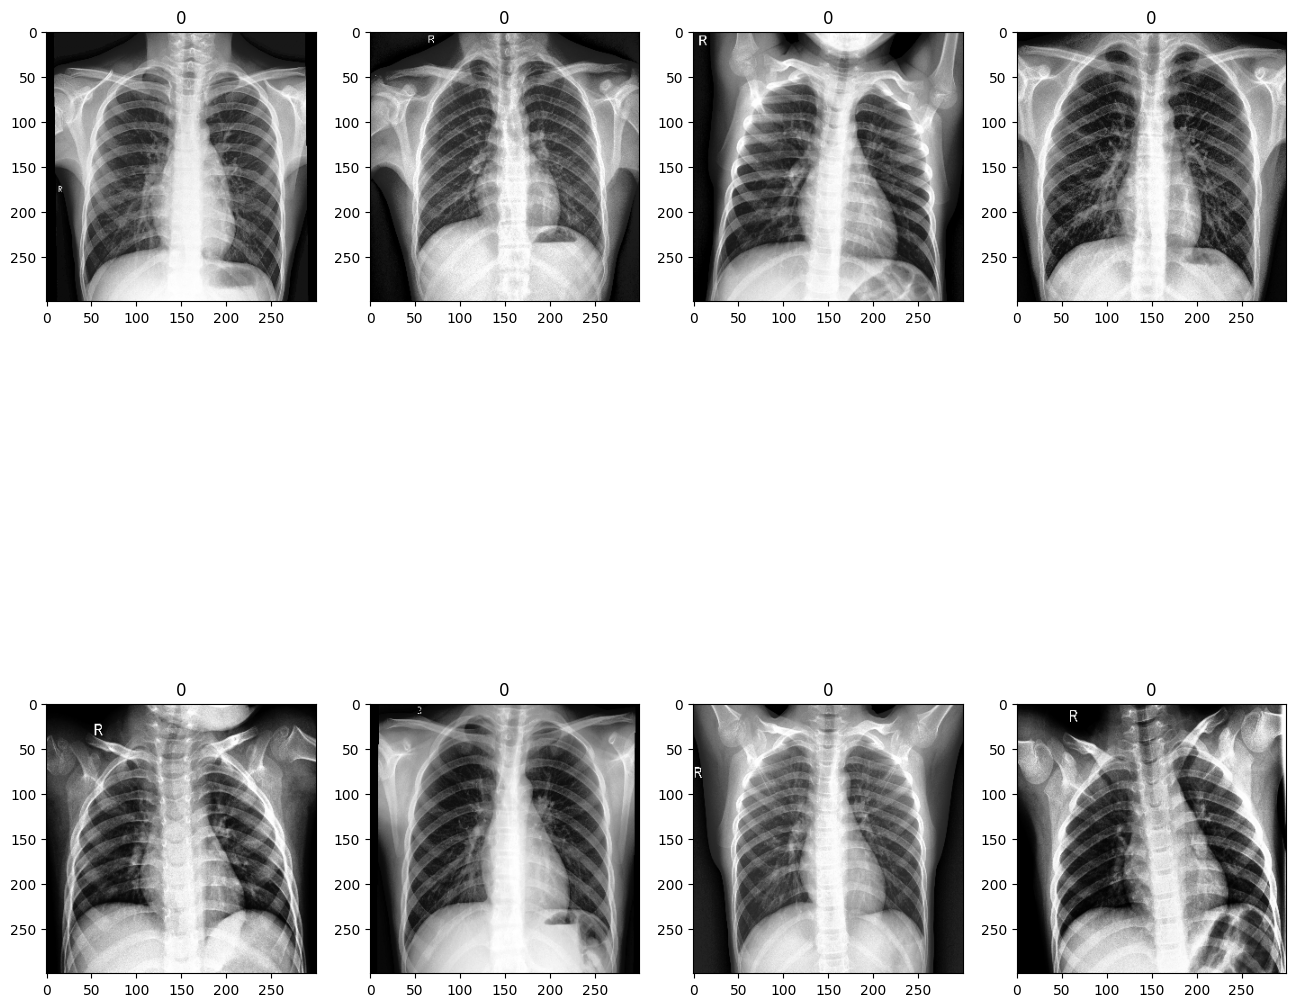

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(train[i])
    plt.title(y_train[i])

# Create the model

In [14]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    #tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(3, activation='softmax')
])

In [15]:
'''num_classes = 3

model = tf.keras.Sequential([
  #tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(300, 300, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])'''

#Model summary
View all the layers of the network using the model's Model.summary method:

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 35, 35, 32)      

#Compile the model
For this project, we choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [17]:
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [18]:
ES = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    min_delta = 0.001,
    verbose = 1)

#Train the model

In [19]:
history = model.fit(
    train_set,
    callbacks=[ES],
    steps_per_epoch = 7,
    epochs = 100,
    validation_data = val_set
)

Epoch 1/100
7/7 [==============================] - 61s 9s/step - loss: 1.0301 - accuracy: 0.5721 - val_loss: 0.8256 - val_accuracy: 0.5600
Epoch 2/100
7/7 [==============================] - 50s 7s/step - loss: 0.5536 - accuracy: 0.7910 - val_loss: 0.3733 - val_accuracy: 0.9000
Epoch 3/100
7/7 [==============================] - 47s 7s/step - loss: 0.2540 - accuracy: 0.8905 - val_loss: 0.3400 - val_accuracy: 0.8800
Epoch 4/100
7/7 [==============================] - 43s 6s/step - loss: 0.2556 - accuracy: 0.8806 - val_loss: 0.5759 - val_accuracy: 0.8600
Epoch 5/100
7/7 [==============================] - 47s 7s/step - loss: 0.1978 - accuracy: 0.9055 - val_loss: 0.3073 - val_accuracy: 0.9200
Epoch 6/100
7/7 [==============================] - 43s 6s/step - loss: 0.1075 - accuracy: 0.9552 - val_loss: 0.3373 - val_accuracy: 0.9200
Epoch 7/100
7/7 [==============================] - 55s 9s/step - loss: 0.0918 - accuracy: 0.9552 - val_loss: 0.2244 - val_accuracy: 0.9200
Epoch 8/100
7/7 [==========

#Visualize training results
Create plots of loss and accuracy on the training and validation sets

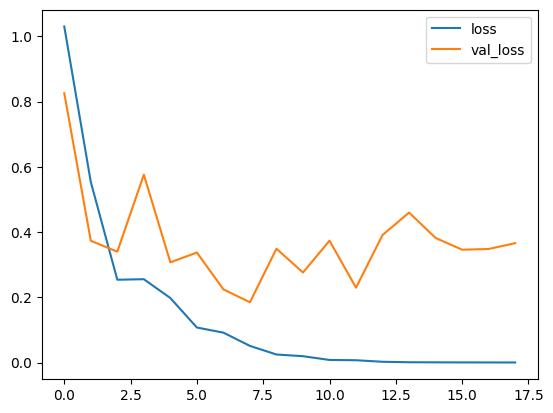

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

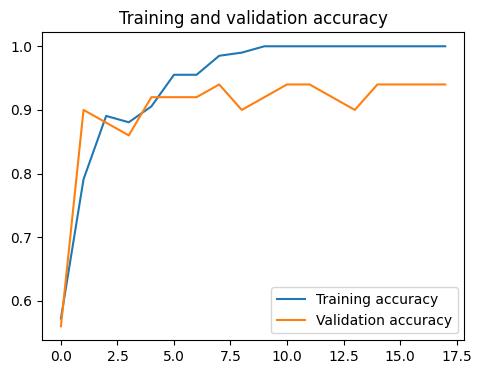

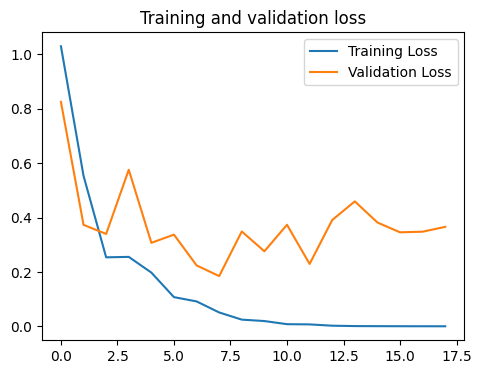

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right')

plt.show()


The plots show that training accuracy and validation accuracy are not off by large margins, and the model has achieved around 90% accuracy on the validation set.

With this, overfitting is not happening but we will still do some data augmentation to find out if we can improve accuracy, precision, recall and f1_score

#Overfitting
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 40% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.

#Predict with test set

In [22]:
prediction = model.predict(test_set)

3/3 [==============================] - 4s 843ms/step


In [23]:
predict = []
for idx in range(prediction.shape[0]):
    predict.append(np.argmax(prediction[idx]))

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(test_set.classes, predict)

0.9090909090909091

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print(classification_report(test_set.classes, predict))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       0.94      0.80      0.86        20
           2       0.86      0.90      0.88        20

    accuracy                           0.91        66
   macro avg       0.91      0.90      0.90        66
weighted avg       0.91      0.91      0.91        66



In [26]:
y_predicted = []
for val in predict:
    y_predicted.append(class_names_lst[val])

In [27]:
true_y = []
for val in test_set.classes:
    true_y.append(class_names_lst[val])

In [28]:
for i, j in zip(true_y, y_predicted):
    print(i, '|', j)

Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Normal | Normal
Normal | Normal
Normal | Normal
Normal | Normal
Normal | Normal
Normal | Viral Pneumonia
Normal | Normal
Normal | Normal
Normal | Normal
Normal | Viral Pneumonia
Normal | Normal
Normal | Normal
Normal | Normal
Normal | Covid
Normal | Normal
Normal | Normal
Normal | Normal
Normal | Normal
Normal | Viral Pneumonia
Normal | Normal
Viral Pneumonia | Viral Pneumonia
Viral Pneumonia | Viral Pneumonia
Viral Pneumonia | Viral Pneumonia
Viral Pneumonia | Viral Pneumonia
Viral Pneumonia | Viral Pneumonia
Viral Pneumonia | Covid
Viral Pneumonia | Viral Pneumonia
Viral Pneumonia | Viral Pneumonia
Viral Pneumonia | Normal
Vir

#Data augmentation
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [29]:
data_augmentation = tf.keras.models.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(300,
                                  300,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [30]:
'''plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")'''

'plt.figure(figsize=(10, 10))\nfor images, labels in train_set.take(1):\n  for i in range(9):\n    augmented_images = data_augmentation(images)\n    ax = plt.subplot(3, 3, i + 1)\n    plt.imshow(augmented_images[0].numpy().astype("uint8"))\n    plt.axis("off")'

#Dropout
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with tf.keras.layers.Dropout before training it using the augmented images

In [31]:
model = tf.keras.models.Sequential([data_augmentation,
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(3)
])

#Compile and train the model

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 71, 71, 64)       

#Train model

In [34]:
history = model.fit(
    train_set,
    callbacks=[ES],
    steps_per_epoch = 7,
    epochs = 100,
    validation_data = val_set
)

Epoch 1/100
7/7 [==============================] - 49s 7s/step - loss: 1.0886 - accuracy: 0.4378 - val_loss: 1.0936 - val_accuracy: 0.2800
Epoch 2/100
7/7 [==============================] - 61s 9s/step - loss: 1.0722 - accuracy: 0.5522 - val_loss: 1.0300 - val_accuracy: 0.7600
Epoch 3/100
7/7 [==============================] - 40s 6s/step - loss: 0.9737 - accuracy: 0.6219 - val_loss: 0.7723 - val_accuracy: 0.5400
Epoch 4/100
7/7 [==============================] - 41s 6s/step - loss: 0.6553 - accuracy: 0.7264 - val_loss: 0.5437 - val_accuracy: 0.8200
Epoch 5/100
7/7 [==============================] - 39s 6s/step - loss: 0.3645 - accuracy: 0.8507 - val_loss: 0.9934 - val_accuracy: 0.7000
Epoch 6/100
7/7 [==============================] - 43s 6s/step - loss: 0.5652 - accuracy: 0.7910 - val_loss: 1.0588 - val_accuracy: 0.6400
Epoch 7/100
7/7 [==============================] - 42s 6s/step - loss: 0.5321 - accuracy: 0.7861 - val_loss: 0.8896 - val_accuracy: 0.7200
Epoch 8/100
7/7 [==========

#Visualize training results
After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

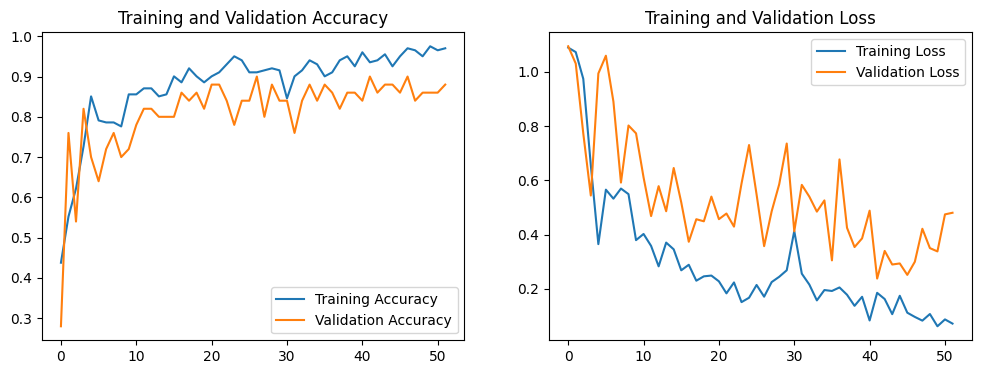

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Evaluate model with test set

In [36]:
model.evaluate(test_set)

3/3 [==============================] - 4s 702ms/step - loss: 0.2829 - accuracy: 0.8788


[0.28286513686180115, 0.8787878751754761]

In [37]:
y_hat = model.predict(test_set)

3/3 [==============================] - 5s 727ms/step


In [38]:
y_hat_lst = []
for idx in range(y_hat.shape[0]):
    y_hat_lst.append(np.argmax(y_hat[idx]))

In [39]:
y_hat_cat = []
for val in y_hat_lst:
    y_hat_cat.append(class_names_lst[val])

In [40]:
true_y_cat = []
for val in test_set.classes:
    true_y_cat.append(class_names_lst[val])

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(test_set.classes, y_hat_lst)

0.8787878787878788

In [42]:
for i, j in zip(true_y_cat[:20], y_hat_cat[:20]):
    print(i, '|', j)

Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Normal
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid
Covid | Covid


In [43]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print(classification_report(test_set.classes, y_hat_lst))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.93      0.70      0.80        20
           2       0.76      0.95      0.84        20

    accuracy                           0.88        66
   macro avg       0.88      0.87      0.87        66
weighted avg       0.89      0.88      0.88        66



#Model Deployment using Tensorflow Lite
TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

#Convert the Keras Sequential model to a TensorFlow Lite model
To use the trained model with on-device applications, first convert it to a smaller and more efficient model format called a TensorFlow Lite model.

In this example, take the trained Keras Sequential model and use tf.lite.TFLiteConverter.from_keras_model to generate a TensorFlow Lite model:

In [44]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

The TensorFlow Lite model you saved in the previous step can contain several function signatures.